In [11]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [12]:
limit_mem()

In [13]:
from keras.datasets.cifar10 import load_batch

# Densenet / CIFAR 10

From http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [4]:
def load_data():
    path = 'data/cifar-10-batches-py'
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(path, 'data_batch_' + str(i)))
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels
    x_test, y_test = load_batch(os.path.join(path, 'test_batch'))
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [5]:
(x_train, y_train), (x_test, y_test) = load_data()

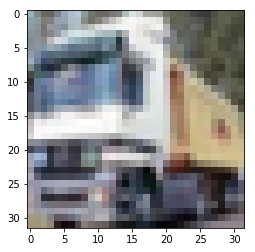

In [6]:
plt.imshow(x_train[1])

In [7]:
x_train = x_train/255.
x_test = x_test/255.

## Densenet

### The pieces

In [1]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=0, axis=-1)(x)
def relu_bn(x): return relu(bn(x))

In [2]:
def conv(x, nf, sz, wd, p):
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                          W_regularizer=l2(wd))(x)
    return dropout(x,p)

In [16]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck: x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p)

In [4]:
def transition_block(x, compression=1.0, p=None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x)
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

In [5]:
def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck: nb_layers //= 2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = merge([x,b], mode='concat', concat_axis=-1)
    return x

### Build the DenseNet model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- bottleneck: add bottleneck blocks
- reduction:  reduction factor of transition blocks.  Note : reduction value is inverted to compute compression
- p: dropout rate
- wd: weight decay
- activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'. Note that if sigmoid is used, classes must be 1.

Returns: keras tensor with nb_layers of conv_block appended

In [6]:
def create_dense_net(nb_classes, img_input, depth=40, nb_block=3, 
     growth_rate=12, nb_filter=16, bottleneck=False, compression=0.0, p=None, wd=0):

    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    for i,block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(nb_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)

    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation='softmax', W_regularizer=l2(wd))(x)

### Train

In [7]:
input_shape = (32,32,3)

In [14]:
img_input = Input(shape=input_shape)

In [17]:
x = create_dense_net(10, img_input, depth=100, nb_filter=16, compression=0.5, 
                     bottleneck=True, p=0.2, wd=1e-4)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 1), padding="same", kernel_initializer="he_uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update you

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 16)    448         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 32, 32, 16)    64          conv2d_2[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 16)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [18]:
model = Model(img_input, x)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', 
      optimizer=keras.optimizers.SGD(0.1, 0.9, nesterov=True), metrics=["accuracy"])

In [19]:
parms = {'verbose': 2, 'callbacks': [TQDMNotebookCallback()]}

In [20]:
K.set_value(model.optimizer.lr, 0.1)

In [21]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
561s - loss: 1.9801 - acc: 0.4810 - val_loss: 2.0473 - val_acc: 0.5045
Epoch 2/20
556s - loss: 1.4368 - acc: 0.6571 - val_loss: 1.8446 - val_acc: 0.5864
Epoch 3/20
547s - loss: 1.2204 - acc: 0.7122 - val_loss: 1.3181 - val_acc: 0.6696
Epoch 4/20
556s - loss: 1.0634 - acc: 0.7547 - val_loss: 1.3620 - val_acc: 0.6658
Epoch 5/20
560s - loss: 0.9536 - acc: 0.7829 - val_loss: 2.6235 - val_acc: 0.4702
Epoch 6/20
557s - loss: 0.8835 - acc: 0.8025 - val_loss: 2.4969 - val_acc: 0.4981
Epoch 7/20
551s - loss: 0.8293 - acc: 0.8155 - val_loss: 1.1944 - val_acc: 0.7281
Epoch 8/20
551s - loss: 0.7949 - acc: 0.8244 - val_loss: 1.1396 - val_acc: 0.7366
Epoch 9/20
551s - loss: 0.7620 - acc: 0.8340 - val_loss: 1.9196 - val_acc: 0.5916
Epoch 10/20
551s - loss: 0.7472 - acc: 0.8389 - val_loss: 2.6207 - val_acc: 0.4900
Epoch 11/20
550s - loss: 0.7251 - acc: 0.8449 - val_loss: 1.4957 - val_acc: 0.6859
Epoch 12/20
551s - loss: 0.7117 - acc: 0.8503 

In [22]:
K.set_value(model.optimizer.lr, 0.01)

In [23]:
model.fit(x_train, y_train, 64, 4, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
550s - loss: 0.5463 - acc: 0.9128 - val_loss: 0.5737 - val_acc: 0.9033
Epoch 2/4
551s - loss: 0.4833 - acc: 0.9311 - val_loss: 0.5695 - val_acc: 0.9033
Epoch 3/4
551s - loss: 0.4575 - acc: 0.9366 - val_loss: 0.5590 - val_acc: 0.9051
Epoch 4/4
550s - loss: 0.4361 - acc: 0.9429 - val_loss: 0.5656 - val_acc: 0.9048



In [24]:
K.set_value(model.optimizer.lr, 0.1)

In [26]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples

Epoch 1/20
551s - loss: 0.6589 - acc: 0.8728 - val_loss: 1.3259 - val_acc: 0.6935
Epoch 2/20
551s - loss: 0.6510 - acc: 0.8766 - val_loss: 0.9672 - val_acc: 0.7880
Epoch 3/20
551s - loss: 0.6508 - acc: 0.8784 - val_loss: 1.1104 - val_acc: 0.7581
Epoch 4/20
551s - loss: 0.6462 - acc: 0.8793 - val_loss: 1.0601 - val_acc: 0.7877
Epoch 5/20
550s - loss: 0.6456 - acc: 0.8816 - val_loss: 0.9799 - val_acc: 0.7876
Epoch 6/20
551s - loss: 0.6427 - acc: 0.8830 - val_loss: 0.9377 - val_acc: 0.8028
Epoch 7/20
551s - loss: 0.6409 - acc: 0.8837 - val_loss: 1.8484 - val_acc: 0.5932
Epoch 8/20
551s - loss: 0.6378 - acc: 0.8831 - val_loss: 1.1806 - val_acc: 0.7420
Epoch 9/20
550s - loss: 0.6381 - acc: 0.8843 - val_loss: 1.0799 - val_acc: 0.7774
Epoch 10/20
551s - loss: 0.6344 - acc: 0.8870 - val_loss: 0.9114 - val_acc: 0.8163
Epoch 11/20
561s - loss: 0.6394 - acc: 0.8858 - val_loss: 0.9710 - val_acc: 0.7982
Epoch 12/20
560s - loss: 0.6367 - acc: 0.8863

In [27]:
K.set_value(model.optimizer.lr, 0.01)

In [28]:
model.fit(x_train, y_train, 64, 40, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
556s - loss: 0.5141 - acc: 0.9320 - val_loss: 0.5652 - val_acc: 0.9165
Epoch 2/40
560s - loss: 0.4530 - acc: 0.9477 - val_loss: 0.5451 - val_acc: 0.9199
Epoch 3/40
560s - loss: 0.4290 - acc: 0.9546 - val_loss: 0.5409 - val_acc: 0.9188
Epoch 4/40
559s - loss: 0.4101 - acc: 0.9584 - val_loss: 0.5259 - val_acc: 0.9224
Epoch 5/40
549s - loss: 0.3934 - acc: 0.9620 - val_loss: 0.5365 - val_acc: 0.9198
Epoch 6/40
551s - loss: 0.3813 - acc: 0.9631 - val_loss: 0.5150 - val_acc: 0.9209
Epoch 7/40
556s - loss: 0.3685 - acc: 0.9644 - val_loss: 0.5238 - val_acc: 0.9197
Epoch 8/40
556s - loss: 0.3565 - acc: 0.9668 - val_loss: 0.5188 - val_acc: 0.9204
Epoch 9/40
555s - loss: 0.3430 - acc: 0.9693 - val_loss: 0.5078 - val_acc: 0.9206
Epoch 10/40
553s - loss: 0.3325 - acc: 0.9707 - val_loss: 0.5107 - val_acc: 0.9191
Epoch 11/40
556s - loss: 0.3220 - acc: 0.9721 - val_loss: 0.5091 - val_acc: 0.9191
Epoch 12/40
556s - loss: 0.3121 - acc: 0.9738 

In [29]:
K.set_value(model.optimizer.lr, 0.001)

In [30]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
547s - loss: 0.1885 - acc: 0.9845 - val_loss: 0.4287 - val_acc: 0.9256
Epoch 2/20
548s - loss: 0.1772 - acc: 0.9886 - val_loss: 0.4198 - val_acc: 0.9279
Epoch 3/20
547s - loss: 0.1734 - acc: 0.9901 - val_loss: 0.4181 - val_acc: 0.9283
Epoch 4/20
547s - loss: 0.1706 - acc: 0.9910 - val_loss: 0.4188 - val_acc: 0.9280
Epoch 5/20
548s - loss: 0.1679 - acc: 0.9918 - val_loss: 0.4127 - val_acc: 0.9298
Epoch 6/20
548s - loss: 0.1670 - acc: 0.9921 - val_loss: 0.4159 - val_acc: 0.9301
Epoch 7/20
548s - loss: 0.1650 - acc: 0.9926 - val_loss: 0.4139 - val_acc: 0.9300
Epoch 8/20
547s - loss: 0.1631 - acc: 0.9933 - val_loss: 0.4087 - val_acc: 0.9304
Epoch 9/20
548s - loss: 0.1619 - acc: 0.9934 - val_loss: 0.4150 - val_acc: 0.9302
Epoch 10/20
547s - loss: 0.1609 - acc: 0.9939 - val_loss: 0.4154 - val_acc: 0.9294
Epoch 11/20
547s - loss: 0.1611 - acc: 0.9933 - val_loss: 0.4102 - val_acc: 0.9310
Epoch 12/20
547s - loss: 0.1584 - acc: 0.9943 

In [31]:
K.set_value(model.optimizer.lr, 0.01)

In [32]:
model.fit(x_train, y_train, 64, 10, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
548s - loss: 0.1819 - acc: 0.9842 - val_loss: 0.4929 - val_acc: 0.9092
Epoch 2/10
547s - loss: 0.2018 - acc: 0.9751 - val_loss: 0.5761 - val_acc: 0.8880
Epoch 3/10
548s - loss: 0.2046 - acc: 0.9742 - val_loss: 0.5411 - val_acc: 0.8950
Epoch 4/10
548s - loss: 0.2008 - acc: 0.9765 - val_loss: 0.5607 - val_acc: 0.8957
Epoch 5/10
548s - loss: 0.1956 - acc: 0.9778 - val_loss: 0.4991 - val_acc: 0.9049
Epoch 6/10
548s - loss: 0.1996 - acc: 0.9760 - val_loss: 0.4714 - val_acc: 0.9112
Epoch 7/10
548s - loss: 0.1947 - acc: 0.9779 - val_loss: 0.5921 - val_acc: 0.8855
Epoch 8/10
547s - loss: 0.1958 - acc: 0.9770 - val_loss: 0.5096 - val_acc: 0.9058
Epoch 9/10
547s - loss: 0.1976 - acc: 0.9754 - val_loss: 0.5129 - val_acc: 0.9041
Epoch 10/10
548s - loss: 0.1940 - acc: 0.9767 - val_loss: 0.5693 - val_acc: 0.8869



In [33]:
K.set_value(model.optimizer.lr, 0.001)

In [34]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
548s - loss: 0.1879 - acc: 0.9801 - val_loss: 0.4073 - val_acc: 0.9270
Epoch 2/20
548s - loss: 0.1631 - acc: 0.9893 - val_loss: 0.4040 - val_acc: 0.9265
Epoch 3/20
547s - loss: 0.1601 - acc: 0.9905 - val_loss: 0.4007 - val_acc: 0.9295
Epoch 4/20
547s - loss: 0.1560 - acc: 0.9919 - val_loss: 0.4016 - val_acc: 0.9294
Epoch 5/20
548s - loss: 0.1540 - acc: 0.9921 - val_loss: 0.3988 - val_acc: 0.9293
Epoch 6/20
547s - loss: 0.1529 - acc: 0.9926 - val_loss: 0.4013 - val_acc: 0.9283
Epoch 7/20
548s - loss: 0.1497 - acc: 0.9937 - val_loss: 0.3984 - val_acc: 0.9312
Epoch 8/20
548s - loss: 0.1508 - acc: 0.9929 - val_loss: 0.3993 - val_acc: 0.9304
Epoch 9/20
547s - loss: 0.1486 - acc: 0.9937 - val_loss: 0.3988 - val_acc: 0.9303
Epoch 10/20
547s - loss: 0.1471 - acc: 0.9938 - val_loss: 0.3978 - val_acc: 0.9302
Epoch 11/20
547s - loss: 0.1460 - acc: 0.9942 - val_loss: 0.3945 - val_acc: 0.9306
Epoch 12/20
547s - loss: 0.1453 - acc: 0.9943 

In [35]:
%time model.save_weights('models/93.h5')

CPU times: user 31.1 s, sys: 452 ms, total: 31.6 s
Wall time: 31.1 s


## End